# Import Data

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)
import nltk
import nltk.corpus
import os
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize 
from nltk.tokenize import TreebankWordTokenizer
from statistics import mean 
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [0]:
#reads the csv file
data = pd.read_csv('/content/drive/My Drive/hate_speech.csv',header=0)

# Data Cleaning

In [0]:
#covert tweets to lowercase
data['Tweet']=data['Tweet'].str.lower()

In [0]:
#removing the urls, mentions, hashtags, rt/tweet/retweet
import re
data['cleanedTweet'] = data['Tweet'].str.replace('http\S+|www.\S+|@\S+|#\S+|^rt|tweet\S+|retweet\S+', '', case=False)

In [0]:
#also remove the non-alphanumeric values 
data['cleanedTweet'] = data.cleanedTweet.str.replace(r'[^a-z\s]', '')
#by now, basically we only have words left 

In [0]:
#remove stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['cleanedTweet_no_stopwords'] = data['cleanedTweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


In [0]:
#basic statistics to see the spread of the data
print(data.describe())
print(len(data)) 
#To see how many groups we have 
print(set(data.Group))

             Rating
count  65535.000000
mean       3.689067
std        1.056389
min        1.000000
25%        3.000000
50%        4.000000
75%        4.000000
max       43.000000
65535
{'spam', 'normal', 'abusive', 'hateful'}


In [0]:
#to see how many tweets we have per group
data.groupby(['Group'])['Rating'].count().sort_values()

Group
hateful     3210
spam        9226
abusive    17806
normal     35293
Name: Rating, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


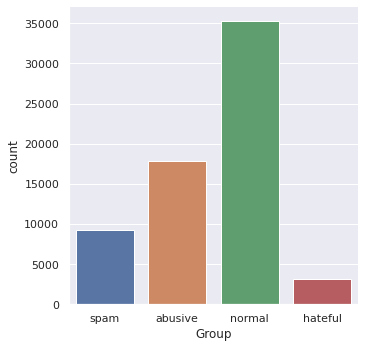

In [0]:
fc = sns.factorplot(x="Group",  
                    data=data, kind="count")

# Tokenization and N-Grams



In [0]:
#generate new column: tokenized_text

data['tokenized_text']  = data['cleanedTweet_no_stopwords'].apply(word_tokenize) 

In [0]:
#find_ngrams function
def find_ngrams(input_list, n):
    return list(zip(*[input_list[i:] for i in range(n)]))

In [0]:
#Unigram
data['Unigrams'] = data['tokenized_text'].map(lambda x: find_ngrams(x, 1))

In [0]:
#Bigrams
data['Bigrams'] = data['tokenized_text'].map(lambda x: find_ngrams(x, 2))

In [0]:
#Trigrams
data['Trigrams'] = data['tokenized_text'].map(lambda x: find_ngrams(x, 3))

# Calculating Frequency of N-grams







In [0]:
# We can change Unigram to Bigram/Trigram, or take subset based on groups to see difference like the following:
# word_list = list(chain(*data.loc[data.Group =='abusive']['Unigrams']))


from itertools import chain
word_list = list(chain(*data['Unigrams']))

In [0]:
#dictionary with the word frequency
from collections import Counter
word_count =Counter(word_list)
word_count.keys()

dict_keys([('beats',), ('dr',), ('dre',), ('urbeats',), ('wired',), ('inear',), ('headphones',), ('white',), ('man',), ('would',), ('fucking',), ('rule',), ('party',), ('perpetual',), ('warfare',), ('time',), ('draw',), ('close',), ('father',), ('near',), ('always',), ('notice',), ('start',), ('act',), ('different',), ('distant',), ('bc',), ('peeped',), ('something',), ('difference',), ('amp',), ('ian',), ('fw',), ('forget',), ('unfollowers',), ('believe',), ('growing',), ('new',), ('followers',), ('last',), ('day',), ('stats',), ('via',), ('hate',), ('sexually',), ('frustrated',), ('like',), ('wan',), ('na',), ('fuck',), ('ion',), ('anybody',), ('topped',), ('group',), ('tgp',), ('disc',), ('jam',), ('season',), ('onto',), ('semifinals',), ('daily',), ('baby',), ('aspirin',), ('might',), ('preventing',), ('colon',), ('liked',), ('video',), ('blue',), ('army',), ('coming',), ('ancient',), ('homies',), ('dont',), ('tell',), ('aint',), ('uber',), ('finds',), ('one',), ('allegedly',), ('s

In [0]:
frequency_df = pd.DataFrame(word_count.most_common(20),columns=['word','frequency'])


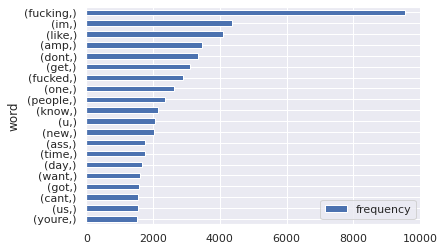

In [0]:
frequency_df.sort_values(by='frequency').plot.barh(x='word',y='frequency')

#Word2vec And Word Embedding

In [0]:
import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [0]:
#word2vec model, default dimension = 100
model = gensim.models.Word2Vec(data.tokenized_text, min_count=1)

In [0]:
#if the text is missing, give 0 with 100 dimensions 
missing=[0]*100
def fun(key):
    try:
        return(model[key])
    except:
        return(missing)

In [0]:
# add a new column of word_embedding
data['word_embedding'] = data['tokenized_text'].apply(fun)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [0]:
# the average of the word embedding vectors 

data['word_embedding'] = data['word_embedding'].map(lambda x: sum(x)/len(x))

In [0]:
# split the word embedding to 100 columns 
word_embedding_splited = data['word_embedding'].apply(pd.Series)

In [0]:
# find out rows with null value after spliting
null_data = word_embedding_splited[word_embedding_splited.isnull().any(axis=1)]

In [0]:
# 281 row of null values, let's replace all na with 0
# why: we don't want to just drop this rows since tweet of these rows contain no normal content, probabobly spam...
# we will have addiontal useful features for these rows
null_data.shape

(281, 100)

In [0]:
# relace null values with 0
word_embedding_splited.fillna(0, inplace=True)

In [0]:
# add the 100 splited word embedding columns to our data
data = pd.concat([data,word_embedding_splited], axis=1)

# Part of Speech Extraction

In [0]:
#part of speech extraction
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag


def preprocess(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent

In [0]:
#new list was created that will then be used to append the data into the dataframe
appended_data=[]

for i in data.cleanedTweet_no_stopwords:
  appended_data.append(preprocess(i))

In [0]:
data["part_speech"]=appended_data

## PART OF SPEECH COUNT

In [0]:
# define some functions to get the number of different category of POS

def findNNS(row):
  count = 0
  for each in row:
    if each[1] in ['NNS','NN','NNP','NNPS',]:
      count+=1
  return count
data['NN'] = data.part_speech.apply(findNNS)

def findCC(row):
  count = 0
  for each in row:
    if each[1] in ['CC','CD']:
      count+=1
  return count
data['CC'] = data.part_speech.apply(findCC)

def findDT(row):
  count = 0
  for each in row:
    if each[1] == 'DT':
      count+=1
  return count
data['DT'] = data.part_speech.apply(findDT)

def findEX(row):
  count = 0
  for each in row:
    if each[1] == 'EX':
      count+=1
  return count
data['EX'] = data.part_speech.apply(findEX)

def findFW(row):
  count = 0
  for each in row:
    if each[1] == 'FW':
      count+=1
  return count
data['FW'] = data.part_speech.apply(findFW)

def findIN(row):
  count = 0
  for each in row:
    if each[1] == 'IN':
      count+=1
  return count
data['IN'] = data.part_speech.apply(findIN)

def findJJ(row):
  count = 0
  for each in row:
    if each[1] in ['JJ','JJR']:
      count+=1
  return count
data['JJ'] = data.part_speech.apply(findJJ)

def findLS(row):
  count = 0
  for each in row:
    if each[1] == 'LS':
      count+=1
  return count
data['LS'] = data.part_speech.apply(findLS)

def findMD(row):
  count = 0
  for each in row:
    if each[1] == 'MD':
      count+=1
  return count
data['MD'] = data.part_speech.apply(findMD)

def findPP(row):
  count = 0
  for each in row:
    if each[1] in ['PDT','POS','PRP','PRP$']:
      count+=1
  return count
data['PP'] = data.part_speech.apply(findPP)

def findRB(row):
  count = 0
  for each in row:
    if each[1] in ['RB','RBR','RBS','RP']:
      count+=1
  return count
data['RB'] = data.part_speech.apply(findRB)

def findSYM(row):
  count = 0
  for each in row:
    if each[1] == 'SYM':
      count+=1
  return count
data['SYM'] = data.part_speech.apply(findSYM)

def findTO(row):
  count = 0
  for each in row:
    if each[1] == 'TO':
      count+=1
  return count
data['TO'] = data.part_speech.apply(findTO)

def findUH(row):
  count = 0
  for each in row:
    if each[1] == 'UH':
      count+=1
  return count
data['UH'] = data.part_speech.apply(findUH)

def findVB(row):
  count = 0
  for each in row:
    if each[1] in ['VB','VBD','VBG','VBN','VBP','VBZ']:
      count+=1
  return count
data['VB'] = data.part_speech.apply(findVB)

def findWB(row):
  count = 0
  for each in row:
    if each[1] in ['WDT','WP','WP$','WRB']:
      count+=1
  return count
data['WB'] = data.part_speech.apply(findWB)



# **Sentiment Analysis**

In [0]:
# since we already have many features in data, let's use different variables here and concatenate data at final stage

data1 = data[['cleanedTweet','Group','Rating']]


In [0]:
data1.head()

,cleanedTweet,Group,Rating
0,beats by dr dre urbeats wired inear headphones...,spam,4
1,man it would fucking rule if we had a party ...,abusive,4
2,it is time to draw close to him father i draw...,normal,4
3,if you notice me start to act different or dis...,normal,5
4,forget unfollowers i believe in growing new f...,normal,3


In [0]:
# count rows of different groups
# put this finding into the report
print('the shape of spam tweet dataset is: ', data1[data1.Group == 'spam'].shape)
print('the shape of hateful tweet dataset is: ', data1[data1.Group == 'hateful'].shape)
print('the shape of abusive tweet dataset is: ', data1[data1.Group == 'abusive'].shape)
print('the shape of normal tweet dataset is: ', data1[data1.Group == 'normal'].shape)

the shape of spam tweet dataset is:  (9226, 3)
the shape of hateful tweet dataset is:  (3210, 3)
the shape of abusive tweet dataset is:  (17806, 3)
the shape of normal tweet dataset is:  (35293, 3)


In [0]:
# We will use vader sentiment analysis here considering short text phrases
!pip install vaderSentiment
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

     |████████████████████████████████| 133kB 2.8MB/s 


In [0]:
#Define the sentiment measurement 

def measure_sentiment(textval):
  sentObj = SentimentIntensityAnalyzer() 
  sentimentvals = sentObj.polarity_scores(textval)
  if sentimentvals['compound']>=0.5: 
    return("Positive")
  elif sentimentvals['compound']<=-0.5:  
    return("Negative")
  else:
    return("Neutral")


In [0]:
# Perform sentiment analysis for the whole tweets dataset
# alert: this code takes 5-10mins to run...

result = []  
for i in data1["cleanedTweet"]:
  result.append(measure_sentiment(i))  
          
data1["sentiment"] = result



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
data1.head()

,cleanedTweet,Group,Rating,sentiment
0,beats by dr dre urbeats wired inear headphones...,spam,4,Neutral
1,man it would fucking rule if we had a party ...,abusive,4,Neutral
2,it is time to draw close to him father i draw...,normal,4,Neutral
3,if you notice me start to act different or dis...,normal,5,Neutral
4,forget unfollowers i believe in growing new f...,normal,3,Neutral


In [0]:
#Check sentiment distribution for each Group

In [0]:
#sentiment distribution for spam tweets dataset
data1[data1.Group=='spam'].groupby(['sentiment'])['cleanedTweet'].count().sort_values()

sentiment
Negative     515
Positive    2301
Neutral     6410
Name: cleanedTweet, dtype: int64

In [0]:
#sentiment distribution for abusive tweets dataset
data1[data1.Group=='abusive'].groupby(['sentiment'])['cleanedTweet'].count().sort_values()

sentiment
Positive     734
Neutral     7740
Negative    9332
Name: cleanedTweet, dtype: int64

In [0]:
#sentiment distribution for normal tweets dataset
data1[data1.Group=='normal'].groupby(['sentiment'])['cleanedTweet'].count().sort_values()

sentiment
Negative     3745
Positive     8889
Neutral     22659
Name: cleanedTweet, dtype: int64

In [0]:
#sentiment distribution for hateful tweets dataset
data1[data1.Group=='hateful'].groupby(['sentiment'])['cleanedTweet'].count().sort_values()

sentiment
Positive     179
Neutral     1247
Negative    1784
Name: cleanedTweet, dtype: int64

In [0]:
# Visualization 1: bar plots for the sentimen distribution for each Group

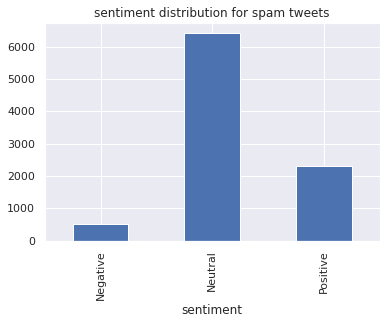

In [0]:
data1[data1.Group=='spam'].groupby(['sentiment'])['cleanedTweet'].count().plot.bar(title='sentiment distribution for spam tweets')

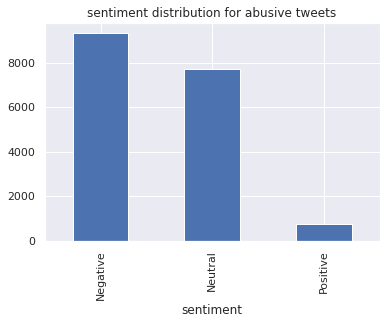

In [0]:
data1[data1.Group=='abusive'].groupby(['sentiment'])['cleanedTweet'].count().plot.bar(title='sentiment distribution for abusive tweets')

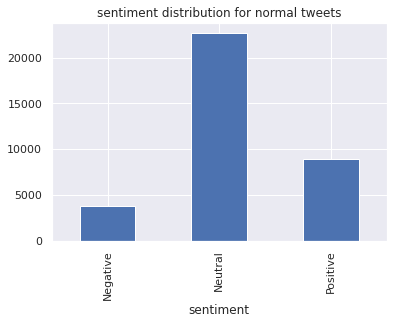

In [0]:
data1[data1.Group=='normal'].groupby(['sentiment'])['cleanedTweet'].count().plot.bar(title='sentiment distribution for normal tweets')

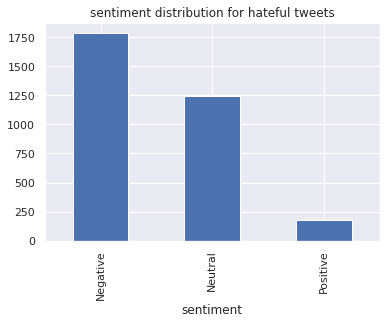

In [0]:
data1[data1.Group=='hateful'].groupby(['sentiment'])['cleanedTweet'].count().plot.bar(title='sentiment distribution for hateful tweets')

In [0]:
# Visualization 2: Bar plot for sentiment analysis grouped by rating(only show rating ≤ 5, when rating >5, values too low)
# why do this: to see whether the number of rating people has influence on the decision
# and the result is yes, that's why we want a machine learning model to do the classification, not human
# we'll take off the rating column in the modeling part, unnecessary

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


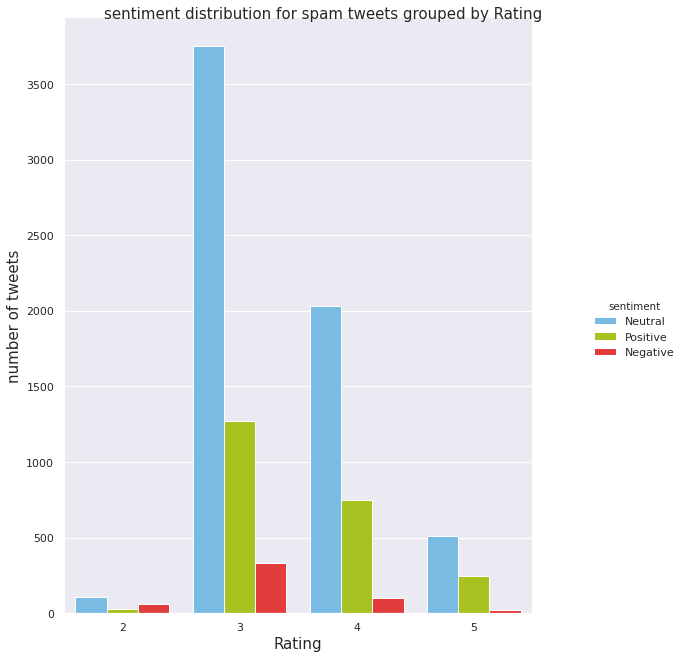

In [0]:

f = sns.factorplot(x="Rating", hue="sentiment", 
                    data=data1[data1.Group=='spam'].loc[data1.Rating<=5], kind="count", 
                    palette={"Negative": "#FE2020", 
                             "Positive": "#BADD07", 
                             "Neutral": "#68BFF5"})

f.fig.suptitle('sentiment distribution for spam tweets grouped by Rating', fontsize= 15)
f.fig.set_size_inches(10, 10)
f.set_xlabels('Rating', fontsize= 15)
f.set_ylabels('number of tweets', fontsize= 15)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


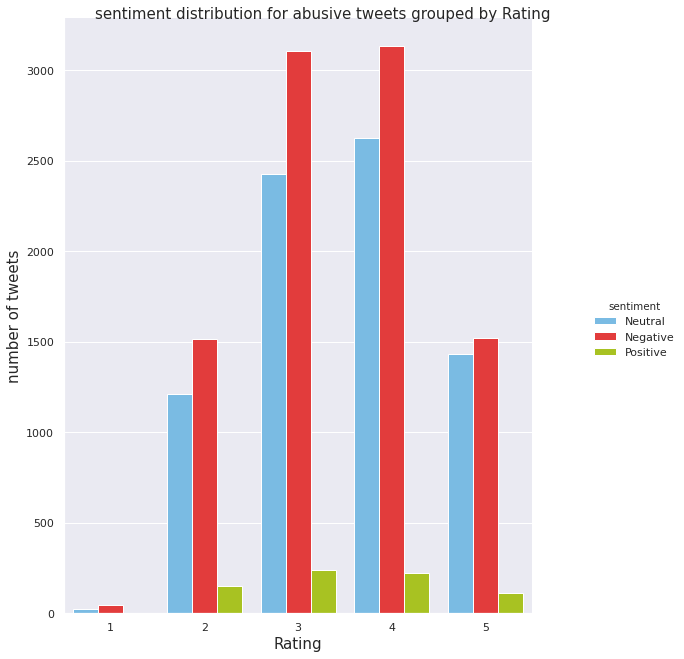

In [0]:
f = sns.factorplot(x="Rating", hue="sentiment", 
                    data=data1[data1.Group=='abusive'].loc[data1.Rating<=5], kind="count", 
                    palette={"Negative": "#FE2020", 
                             "Positive": "#BADD07", 
                             "Neutral": "#68BFF5"})

f.fig.suptitle('sentiment distribution for abusive tweets grouped by Rating', fontsize= 15)
f.fig.set_size_inches(10, 10)
f.set_xlabels('Rating', fontsize= 15)
f.set_ylabels('number of tweets', fontsize= 15)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


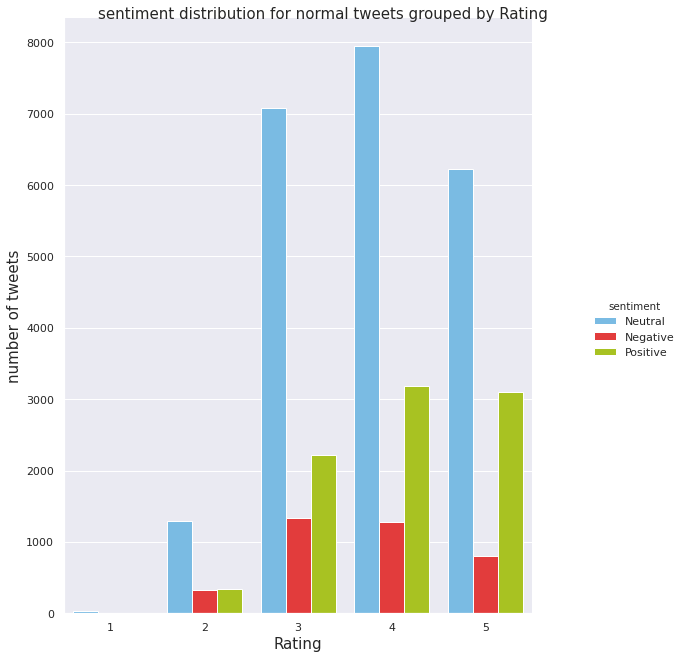

In [0]:
f = sns.factorplot(x="Rating", hue="sentiment", 
                    data=data1[data1.Group=='normal'].loc[data1.Rating<=5], kind="count", 
                    palette={"Negative": "#FE2020", 
                             "Positive": "#BADD07", 
                             "Neutral": "#68BFF5"})

f.fig.suptitle('sentiment distribution for normal tweets grouped by Rating', fontsize= 15)
f.fig.set_size_inches(10, 10)
f.set_xlabels('Rating', fontsize= 15)
f.set_ylabels('number of tweets', fontsize= 15)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


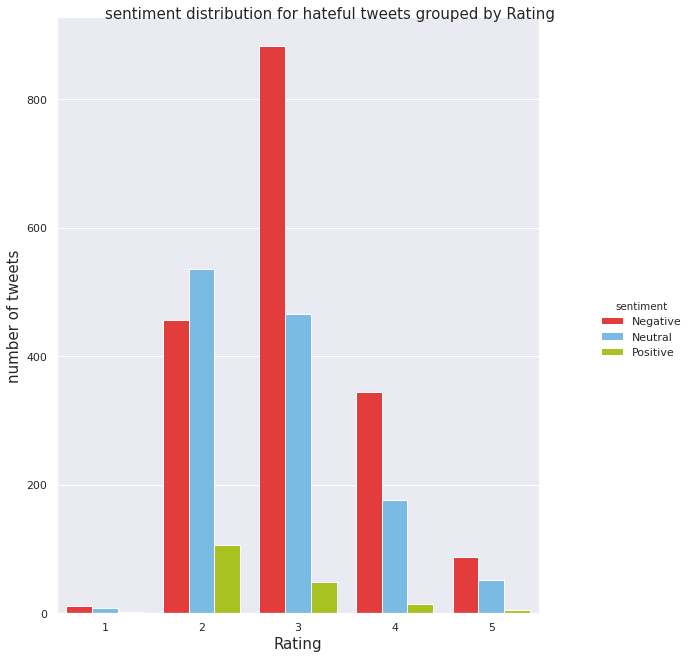

In [0]:
f = sns.factorplot(x="Rating", hue="sentiment", 
                    data=data1[data1.Group=='hateful'].loc[data1.Rating<=5], kind="count", 
                    palette={"Negative": "#FE2020", 
                             "Positive": "#BADD07", 
                             "Neutral": "#68BFF5"})

f.fig.suptitle('sentiment distribution for hateful tweets grouped by Rating', fontsize= 15)
f.fig.set_size_inches(10, 10)
f.set_xlabels('Rating', fontsize= 15)
f.set_ylabels('number of tweets', fontsize= 15)

In [0]:
# Visualization 3: Bar plot for sentiment analysis grouped by Group

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


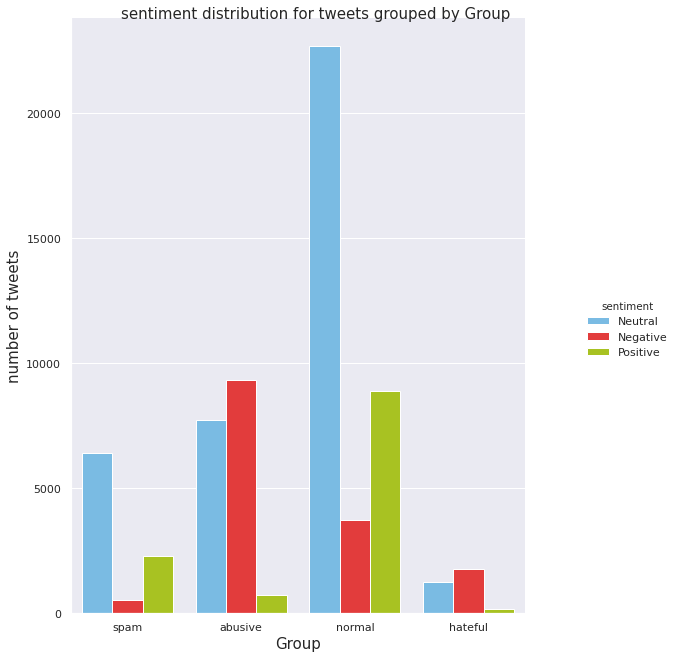

In [0]:
f = sns.factorplot(x="Group", hue="sentiment", 
                    data=data1, kind="count", 
                    palette={"Negative": "#FE2020", 
                             "Positive": "#BADD07", 
                             "Neutral": "#68BFF5"})

f.fig.suptitle('sentiment distribution for tweets grouped by Group', fontsize= 15)
f.fig.set_size_inches(10, 10)
f.set_xlabels('Group', fontsize= 15)
f.set_ylabels('number of tweets', fontsize= 15)

# **LIWC** **Analysis** 

In [0]:
# get tokens for the LIWC analysis
data1.tokens = data1['cleanedTweet'].apply(word_tokenize) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [0]:
# copy the langs folder to "/content"

!cp "/content/drive/My Drive/langs" -r "/content"

In [0]:
# cp the python module to "/content"
!cp "/content/drive/My Drive/find_liwc_topics.py" -r "/content"

In [0]:
#import the LIWC module and define liwc, find the liwc categories for every tweet
import find_liwc_topics
from find_liwc_topics import LIWCParser

LIWC =[]
for tokens in data1.tokens[0:65535]:
  liwc = LIWCParser("LIWC2007_English080730.dic")
  LIWC.append(liwc.parseDoc(tokens))

data1['LIWC'] = LIWC

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [0]:
data1.LIWC

0        [[], [funct, preps], [bio, health], [], [], []...
1        [[social, humans], [funct, pronoun, ipron], [v...
2        [[funct, pronoun, ipron], [verb, funct, auxver...
3        [[funct, conj, cogmech, discrep, tentat, excl]...
4        [[], [], [funct, pronoun, ppron, i], [verb, pr...
                               ...                        
65530    [[], [social], [funct, pronoun, ppron, i], [],...
65531                                                   []
65532    [[affect, negemo, sad, death], [], [funct, pre...
65533    [[funct, quant, cogmech, tentat], [funct, prep...
65534    [[], [], [funct, preps], [], [verb, funct, aux...
Name: LIWC, Length: 65535, dtype: object

# Organizing result we have now 

In [0]:
# add the sentimen and LIWC result to data, now we have data2 containing word embedding, part of speeech, sentimen and liwc result
data2 = pd.concat([data1,data], axis=1)

In [0]:
# drop some unnecessary columns and remove duplicate columns 
data3 = data2.drop(['cleanedTweet','Rating','Tweet','cleanedTweet_no_stopwords','tokenized_text','Bigrams','Trigrams','Unigrams','word_embedding','part_speech'], axis=True)
data3 = data3.loc[:,~data3.columns.duplicated()]

In [0]:
# again, lets get the sentiment score as a new feature, not the tag(previously, we use the tag'positive, negative, neutral' to do visulization)

sentObj = SentimentIntensityAnalyzer() 

result_score = []  
for i in data1["cleanedTweet"]:
  result_score.append(sentObj.polarity_scores(i)['compound'])    

data3["sentiment_score"] = result_score

In [0]:
# remove empty LIWC result 
for i in data3.LIWC:
  for j in i:
    if j ==[]:
      i.remove(j)

In [0]:
# count number of words that gives LIWC results 
result =[]

for i in data3.LIWC:
  result.append(len(i))

data3['LIWC_#words'] = result

In [0]:
# flatten the LIWC result for future work
flatten =[]

for i in data3.LIWC:
  flatten.append(sum(i, []))

data3['LIWC_flatten'] = flatten

In [0]:
#get unique category
unique_category_each_row=[]

for i in data3.LIWC:
  unique_category_each_row.append(list(set(chain(*i))))

unique_category=list(set(chain(*unique_category_each_row)))

#print all the category 
#print the number of LIWC category we have
print(unique_category)
print(len(unique_category))

['space', 'sexual', 'we', 'verb', 'body', 'friend', 'funct', 'anger', 'insight', 'inhib', 'tentat', 'swear', 'quant', 'pronoun', 'filler', 'certain', 'negate', 'number', 'future', 'excl', 'shehe', 'percept', 'hear', 'nonfl', 'time', 'present', 'family', 'sad', 'cogmech', 'ppron', 'incl', 'home', 'they', 'past', 'auxverb', 'motion', 'work', 'discrep', 'relativ', 'posemo', 'you', 'death', 'preps', 'ingest', 'money', 'negemo', 'leisure', 'affect', 'cause', 'adverb', 'health', 'achieve', 'anx', 'see', 'bio', 'article', 'i', 'feel', 'relig', 'assent', 'conj', 'social', 'humans', 'ipron']
64


In [0]:
# calculate the frequancy of each category of LIWC 
result=[]

for i in data3['LIWC_flatten']:
  for x in unique_category:
    result.append(i.count(x))

# reshape the result
result = pd.DataFrame(result)
result = pd.DataFrame(result.values.reshape(65535,64))

In [0]:
# change columns names to category name

result.columns = unique_category

In [0]:
# get mean frequency of each category of LIWC (result divided by number of effective words)

result['LIWC_#words'] = data3['LIWC_#words']
result = result.iloc[:,:-1].div(result['LIWC_#words'], axis = 0) 

# round to two digits
result = result.round(2)

In [0]:
# append the final LIWC result to data3

data4 = pd.concat([data3,result], axis=1).round(2)


In [0]:
# drop some unnecessary columns

data4 = data4.drop(['sentiment','LIWC','LIWC_#words','LIWC_flatten'], axis=True)

In [0]:
# now we only have numbers and targte variable left
data4.head()

,Group,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,time,present,family,sad,cogmech,ppron,incl,home,they,past,auxverb,motion,work,discrep,relativ,posemo,you,death,preps,ingest,money,negemo,leisure,affect,cause,adverb,health,achieve,anx,see,bio,article,i,feel,relig,assent,conj,social,humans,ipron
0,spam,-0.11,0.45,-0.13,0.05,0.11,-0.62,-0.13,0.22,-0.37,-0.06,0.11,0.05,-0.05,-0.21,-0.37,0.12,-0.06,-0.01,0.11,-0.14,0.06,0.21,0.18,-0.09,-0.24,0.04,-0.32,-0.15,0.34,-0.15,-0.12,-0.09,0.06,0.25,0.47,0.24,-0.06,-0.03,-0.14,...,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.20,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.2,0.0,0.0,0.0,0.20,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00
1,abusive,0.06,1.01,0.03,-0.15,-0.01,-0.54,-0.35,0.73,-0.63,-0.48,-0.13,0.08,0.12,-0.16,-0.76,0.52,0.12,-0.09,0.39,-0.65,0.44,0.27,0.03,-0.00,-0.35,0.18,-0.54,-0.48,0.55,-0.25,-0.31,-0.27,0.09,0.32,0.56,0.42,-0.21,0.03,-0.86,...,0.00,0.00,0.0,0.0,0.25,0.08,0.08,0.0,0.0,0.17,0.25,0.00,0.0,0.17,0.00,0.0,0.00,0.0,0.08,0.0,0.0,0.08,0.0,0.08,0.00,0.00,0.0,0.0,0.0,0.0,0.08,0.08,0.00,0.0,0.0,0.0,0.08,0.17,0.08,0.17
2,normal,-0.11,0.97,-0.04,-0.17,0.01,-0.50,-0.26,0.50,-0.92,-0.41,0.17,0.19,0.08,-0.16,-0.71,0.39,0.01,0.13,0.11,-0.49,0.34,0.34,0.18,-0.11,-0.24,0.11,-0.58,-0.38,0.84,-0.33,-0.26,-0.27,0.07,0.48,0.71,0.42,-0.21,-0.09,-0.59,...,0.18,0.09,0.0,0.0,0.27,0.27,0.18,0.0,0.0,0.00,0.09,0.00,0.0,0.00,0.36,0.0,0.09,0.0,0.18,0.0,0.0,0.00,0.0,0.00,0.00,0.09,0.0,0.0,0.0,0.0,0.00,0.00,0.09,0.0,0.0,0.0,0.09,0.18,0.00,0.09
3,normal,-0.04,0.81,-0.07,-0.16,0.01,-0.40,-0.30,0.46,-0.63,-0.39,0.07,0.05,0.02,-0.13,-0.67,0.42,0.04,0.03,0.17,-0.44,0.31,0.22,0.05,-0.13,-0.30,0.11,-0.46,-0.36,0.55,-0.18,-0.18,-0.21,0.11,0.43,0.53,0.30,-0.16,-0.05,-0.57,...,0.05,0.05,0.0,0.0,0.16,0.16,0.00,0.0,0.0,0.05,0.05,0.05,0.0,0.05,0.21,0.0,0.05,0.0,0.11,0.0,0.0,0.00,0.0,0.00,0.05,0.05,0.0,0.0,0.0,0.0,0.00,0.05,0.11,0.0,0.0,0.0,0.16,0.05,0.00,0.11
4,normal,-0.35,0.99,-0.46,0.21,0.18,-1.13,-0.04,0.25,-1.19,-0.19,0.65,0.40,0.19,-0.27,-0.85,0.36,-0.19,0.28,-0.23,-0.30,0.10,0.65,0.49,-0.03,0.06,-0.04,-0.80,-0.26,1.31,-0.50,-0.30,-0.49,0.14,0.54,1.08,0.65,0.00,-0.35,-0.20,...,0.10,0.10,0.0,0.0,0.10,0.10,0.00,0.0,0.0,0.00,0.00,0.10,0.0,0.00,0.30,0.0,0.00,0.0,0.10,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.10,0.10,0.0,0.0,0.0,0.00,0.00,0.00,0.00


# **Modeling and accuracy**

In [0]:
#copy the data we have
df = data4

# normalization for POS 
#POS columns index is from 100-116
df.iloc[ :,100:116]=(df.iloc[ :,100:116]-df.iloc[ :,100:116].min())/(df.iloc[ :,100:116].max()-df.iloc[ :,100:116].min())


In [0]:
# replace missing value with 0
df = df.fillna(0)

In [0]:
# Separating out the features
x = df.drop(['Group'], axis =1).values
# Separating out the target
y = df.loc[:,['Group']].values

In [0]:
# PCA 
from sklearn.decomposition import PCA

pca = PCA(n_components=10)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3','principal component 4',
                          'principal component 5','principal component 6','principal component 7','principal component 8',
                          'principal component 9', 'principal component 10'])

In [0]:
# explained varaiance ratio
# explanied 95% variance, we just use these 10 features as input for the modeling

pca.explained_variance_ratio_

array([0.56458581, 0.13122205, 0.06519625, 0.04423387, 0.02906594,
       0.02563837, 0.02193526, 0.01828985, 0.01089095, 0.00960248])

In [0]:
#final dafaframe used for modeling

finalDf = pd.concat([principalDf, df[['Group']]], axis = 1)

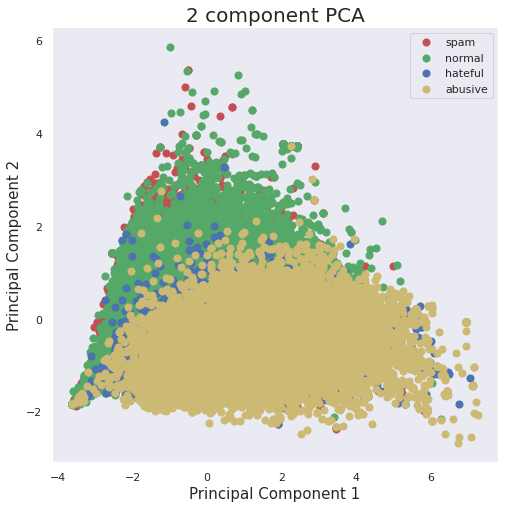

In [0]:
# Visulaize the 2D Projection

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['spam', 'normal', 'hateful','abusive']
colors = ['r', 'g', 'b','y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Group'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [0]:
finalDf

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,Group
0,-2.236874,-0.461637,0.230925,0.366717,0.056680,-0.038151,0.110721,-0.022652,0.079694,-0.205783,spam
1,0.857906,-0.229712,-0.385374,0.132801,0.450090,0.027650,-0.022179,0.028607,-0.010311,0.188693,abusive
2,0.350412,0.554449,-0.383690,-0.151837,-0.275647,0.139724,0.049428,-0.201558,-0.186592,0.162774,normal
3,-0.199983,-0.188348,-0.288547,-0.093645,-0.063792,0.184752,0.163809,-0.000051,0.115677,0.100104,normal
4,-0.565350,2.504592,0.151291,0.450613,-0.656065,-0.357604,-0.226880,-0.026065,-0.444935,-0.210507,normal
...,...,...,...,...,...,...,...,...,...,...,...
65530,-0.440826,-0.023124,-0.515784,0.388947,0.022356,0.499939,-0.317562,0.533577,0.018713,0.018853,abusive
65531,-3.619696,-1.831395,-0.481651,-0.540248,-0.076068,-0.147071,0.178194,-0.054124,0.094648,-0.244465,spam
65532,-1.739361,0.322162,0.573446,0.958432,-0.452040,0.065041,-0.410191,0.195884,-0.234755,-0.117292,normal
65533,-0.510927,-0.267286,0.138363,0.266357,-0.300831,0.347152,-0.409270,0.260030,-0.107764,0.065808,abusive


In [0]:
# save this for future use, because it takes long long time the run the previous code...
from google.colab import files
finalDf.to_csv('finalDf.csv')
files.download('finalDf.csv')

In [0]:
# Separating out the features
x = finalDf.drop(['Group'], axis =1).values
# Separating out the target
y = finalDf.loc[:,['Group']].values


In [0]:
#train/test split
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(x, y, 
                                                    train_size=0.7,
                                                    test_size=0.3,
                                                    random_state=122,
                                                    stratify=y)

In [0]:
# Model 1: KNN Classifier
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier()

classifier.fit(train_X, train_y)

pred_y = classifier.predict(test_X)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """


In [0]:
# train accuracy of KNN
# Classifier score:  0.8037668396041331


print("Classifier score: ", classifier.score(train_X, train_y) )

Classifier score:  0.8037668396041331


In [0]:
# out of sample accuracy of KNN
# Classifier score:  0.7458420222776054


print("Classifier score: ", classifier.score(test_X, test_y) )


Classifier score:  0.7458420222776054


In [0]:
# Model 2: Support vector Classifier

from sklearn.svm import SVC
from sklearn import metrics

svc = SVC(kernel='rbf')
svc.fit(train_X, train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
svcpred = svc.predict(test_X)
print("Accuracy SVM:",metrics.accuracy_score(test_y, svcpred))
#Accuracy SVM: 0.7629825542953055

Accuracy SVM: 0.7629825542953055


In [0]:
# Model 3: Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=2, random_state=0)
rf.fit(train_X, train_y)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [0]:
rfpred = rf.predict(test_X)

In [0]:
# accuracy of Random forest

print("Accuracy of Random Forest: ", metrics.accuracy_score(test_y, rfpred) )
# Accuracy of Random Forest:  0.7665937643049693

Accuracy of Random Forest:  0.7665937643049693


In [0]:
# Rnadom forest word better 
# Parameter tunning
accuracy =[]
for i in range(100,200):
  rf = RandomForestClassifier(n_estimators=i)
  rf.fit(train_X, train_y)
  rfpred = rf.predict(test_X)
  accuracy.append(metrics.accuracy_score(test_y, rfpred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  af

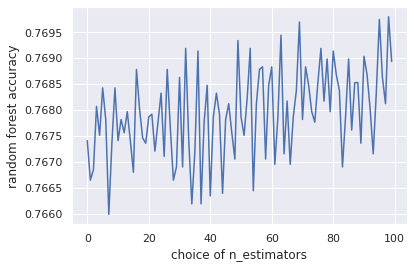

In [0]:
import matplotlib.pyplot as plt
plt.plot(accuracy)
plt.ylabel('random forest accuracy')
plt.xlabel('choice of n_estimators')

plt.show()


In [0]:
# find the max accuracy when n is betwwen 100-199
max(accuracy)
# 0.77